<a href="https://colab.research.google.com/github/online6731/Vehicle-Classification/blob/main/Vehicle_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)


# Problem

## Vehicle Classification by Size

Data is gathered from pictures of vehicles in highways.
<img src='https://github.com/online6731/Vehicle-Classification/blob/main/dataset-info-1.jpg?raw=true'>

Each record in dataset contains the location of vehicle and it's class.

<img src='https://github.com/online6731/Vehicle-Classification/blob/main/dataset-info-2.png?raw=true'>

\#Classes: Bus, Microbus, Minivan, Sedan, SUV, and Truck. 


\#Frequency: 558, 883 , 476 , 5,922, 1,392, and 822. 

# Prepare the Environmet

## Imports

In [50]:
import re
import itertools
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# from pandas.plotting import parallel_coordinates
# from matplotlib.ticker import NullFormatter
# from mpl_toolkits.mplot3d import Axes3
# import matplotlib.ticker as ticker
# from sklearn import preprocessing

from sklearn import tree
from sklearn.preprocessing import LabelEncoder , OneHotEncoder
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.metrics import accuracy_score,recall_score,plot_confusion_matrix
from sklearn.metrics import classification_report,f1_score,precision_score

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

matplotlib.rcParams['figure.figsize'] = (22, 10)


# axis = lambda w,h: plt.figure(figsize=(w, h)).add_subplot()

## Modules

In [126]:
def model_test(model, train, test, params, ax=None):
    # run a grid search for model on parameter space and plots the results

    param_list = list(itertools.product(*params.values()))
    params_ = [dict(zip(params.keys(), param)) for param in param_list]

    param_short_name = lambda param: re.sub(r"([_'][a-z])[a-z]*", r'\1', "".join(map(str, param.items()))).replace(', ', '=').replace("'", "").replace(")(", ", ").upper()

    models = { f'DT{param_short_name(param)}':model(**param).fit(train, train.index) for param in params_}

    result = {
        'train': [accuracy_score(train.index, model.predict(train)) for model in models.values()], 
        'test': [accuracy_score(test.index, model.predict(test)) for model in models.values()]}
    
    result['name'] = [f"{name} = {result['test'][i]:.3f}" for i,name in enumerate(models.keys())]
    result.update({name:[param[name] for i,param in enumerate(params_)] for name in params.keys()})

    result = pd.DataFrame(result).sort_values(list(params.keys())).sort_values('test', ascending=False)# .head(10)

    ax = plt.figure(figsize=(10, len(models) // 3)).add_subplot()
    sns.barplot(x="train", y="name", data=result, orient='h', color='lightblue', ax=ax)
    sns.barplot(x="test", y="name", data=result, orient='h', color='blue', ax=ax)
    # result.drop(columns=params.keys()).plot.bar(rot=90, yticks=np.arange(1,0,-.1), grid=True, figsize=(20,5));

    return result



def plot_decision_surface(model, train, test, ax=None, title=''):
    # plots the decision srface for given model

    if ax:
        ax.set_title(title)
    
    dots = np.dstack(np.meshgrid(np.arange(train['width'].min(), train['width'].max(), 1),
                                 np.arange(train['height'].min(), train['height'].max(), 1))).reshape(-1, 2)

    dots = pd.DataFrame({'width': dots[:,0], 
                         'height': dots[:,1], 
                         'Prediction': model.predict(dots)})

    sns.scatterplot(data=dots, x='width', y='height', hue='Prediction',
                    hue_order=sorted(train.index.unique()),
                    linewidth=0, legend=False, ax=ax)

    sns.scatterplot(data=test.reset_index(), x='width', y='height', hue='name',
                    hue_order=sorted(train.index.unique()),
                    # s=20, linewidth=.1, 
                    linestyle='-', ax=ax);

param_full_name = lambda param: ''.join(map(str, param.items())).replace(', ', '=').replace("'", "").replace(")(", ", ")


## Load the Dataset

In [53]:
df = pd.read_csv('https://github.com/online6731/Vehicle-Classification/blob/main/vehicles.csv?raw=true',
                 names=['x1', 'y1', 'x2', 'y2', 'name'])
df.set_index('name', inplace=True)
df

x1  y1   x2   y2
name                    
suv    129   0  202   73
suv     86  61  189  189
suv    129  21  210  116
sedan  145   1  212   66
sedan  108  73  201  183
...    ...  ..  ...  ...
truck  126   0  325  187
truck  101   0  297  195
truck  107   0  300  180
truck  121   0  326  186
truck   65   0  273  202

[10053 rows x 4 columns]

# Dataset

## Remove Wrong Records

In [54]:
df = df[(df['x1'] <= df['x2']) &
        (df['y1'] <= df['y2']) &
        (0 <= df['x1']) &
        (0 <= df['x2']) &
        (0 <= df['y1']) &
        (0 <= df['y2'])]
df

x1  y1   x2   y2
name                    
suv    129   0  202   73
suv     86  61  189  189
suv    129  21  210  116
sedan  145   1  212   66
sedan  108  73  201  183
...    ...  ..  ...  ...
truck  126   0  325  187
truck  101   0  297  195
truck  107   0  300  180
truck  121   0  326  186
truck   65   0  273  202

[10053 rows x 4 columns]

## Find new Features

In [55]:
df['width'] = df['x2'] - df['x1']
df['height'] = df['y2'] - df['y1']
df['diameter'] = np.sqrt(df['width']**2 + df['height']**2)
df['area'] = df['width'] * df['height']
df

x1  y1   x2   y2  width  height    diameter   area
name                                                      
suv    129   0  202   73     73      73  103.237590   5329
suv     86  61  189  189    103     128  164.295466  13184
suv    129  21  210  116     81      95  124.843903   7695
sedan  145   1  212   66     67      65   93.348808   4355
sedan  108  73  201  183     93     110  144.045132  10230
...    ...  ..  ...  ...    ...     ...         ...    ...
truck  126   0  325  187    199     187  273.075081  37213
truck  101   0  297  195    196     195  276.479656  38220
truck  107   0  300  180    193     180  263.910970  34740
truck  121   0  326  186    205     186  276.804986  38130
truck   65   0  273  202    208     202  289.944822  42016

[10053 rows x 8 columns]

# Dataset Overview

## Scatter Plots

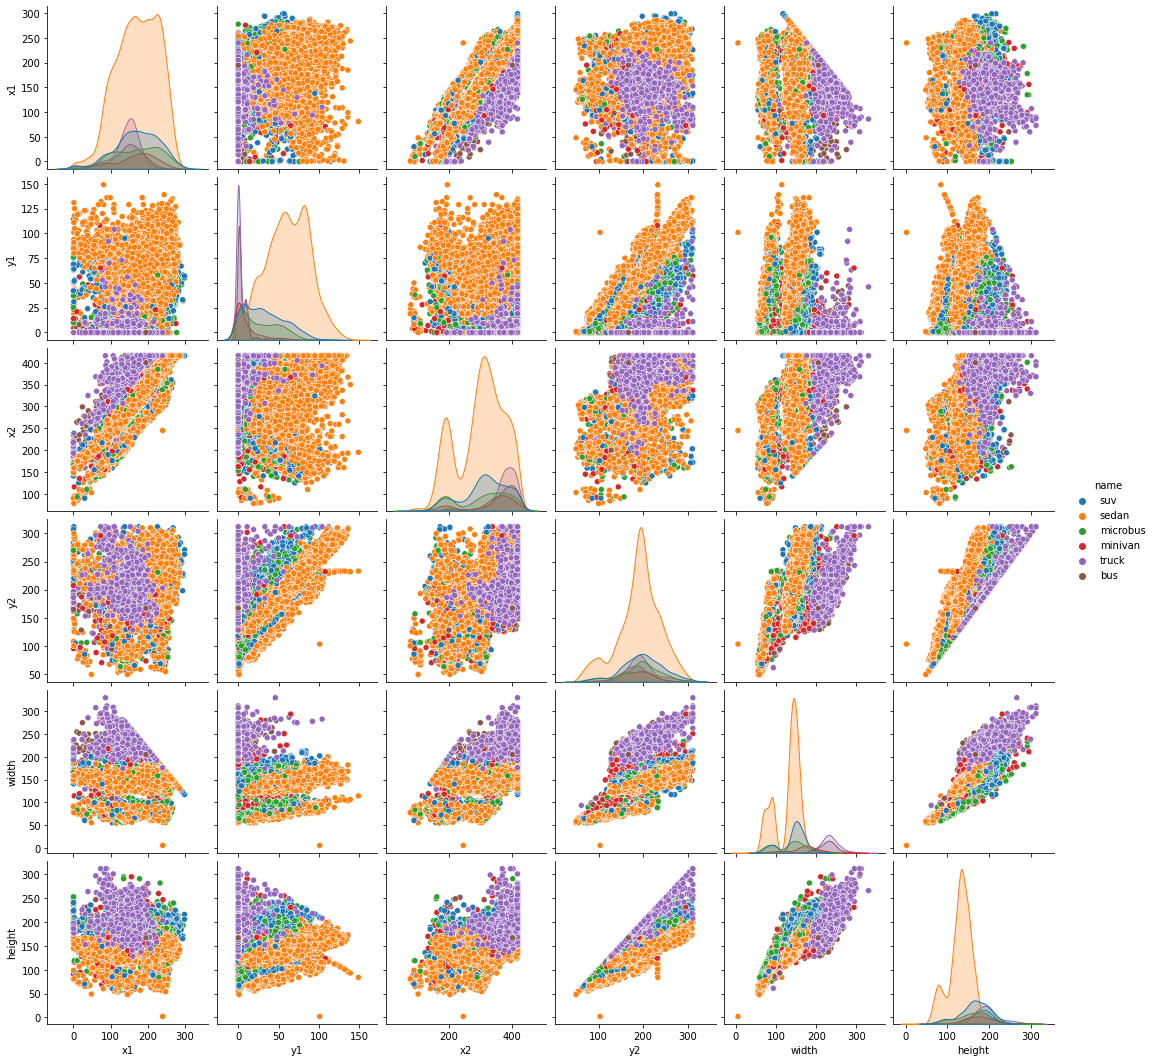

In [56]:
sns.pairplot(df.drop(columns=['diameter', 'area']).reset_index(),
             hue='name');

## Violin Plots

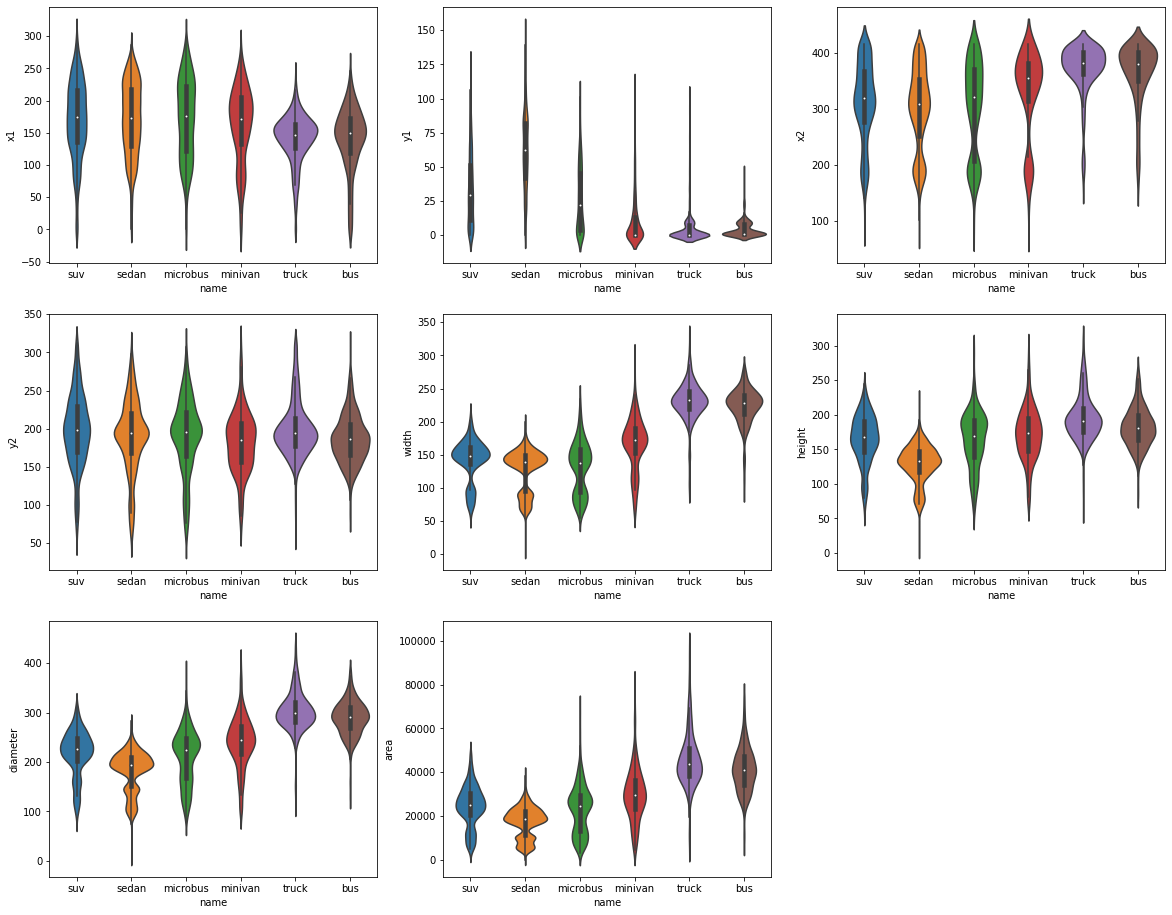

In [57]:
fig = plt.subplots(figsize=(20,16))

for i, column in enumerate(df.columns):
    sns.violinplot(x=df.index,
                   y=column,
                   data=df,
                   ax=plt.subplot(f'33{i+1}'))

# Classification

## Comparison of Algorithms
Models with Default Parameters


### Scores

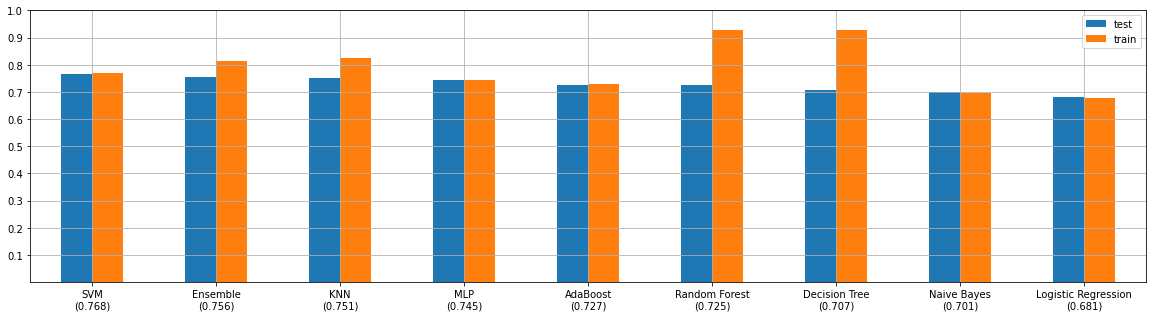

In [67]:
train, test = train_test_split(df.drop(columns=['x1', 'y1', 'x2', 'y2', 'area', 'diameter']),
                               test_size=0.2,
                               random_state=1)

models = {'Decision Tree': DecisionTreeClassifier(),
          'Logistic Regression': LogisticRegression(),
          'KNN': KNeighborsClassifier(),
          'Naive Bayes': GaussianNB(),
          'SVM': SVC(),
          'AdaBoost': AdaBoostClassifier(),
          'Random Forest': RandomForestClassifier(),
          'MLP': MLPClassifier()}
models['Ensemble'] = VotingClassifier(list(models.items()))

# training all the models
models = {name:model.fit(train, train.index) for name, model in models.items()}

result = {'name': models.keys(),
          'test': [accuracy_score(test.index, model.predict(test)) for model in models.values()],
          'train': [accuracy_score(train.index, model.predict(train)) for model in models.values()]}

# model name with accuracy score - example: SVM (0.789)
result['show_name'] = [f"{name}\n({result['test'][i]:.3f})" for i,name in enumerate(models.keys())]

result = pd.DataFrame(result,
                      index=result['show_name']
                      ).sort_values('test', ascending=False)

result.plot.bar(rot=0,
                grid=True,
                figsize=(20,5),
                yticks=np.arange(1,0,-.1));

#### Explanation
...

### Confusion Matrix

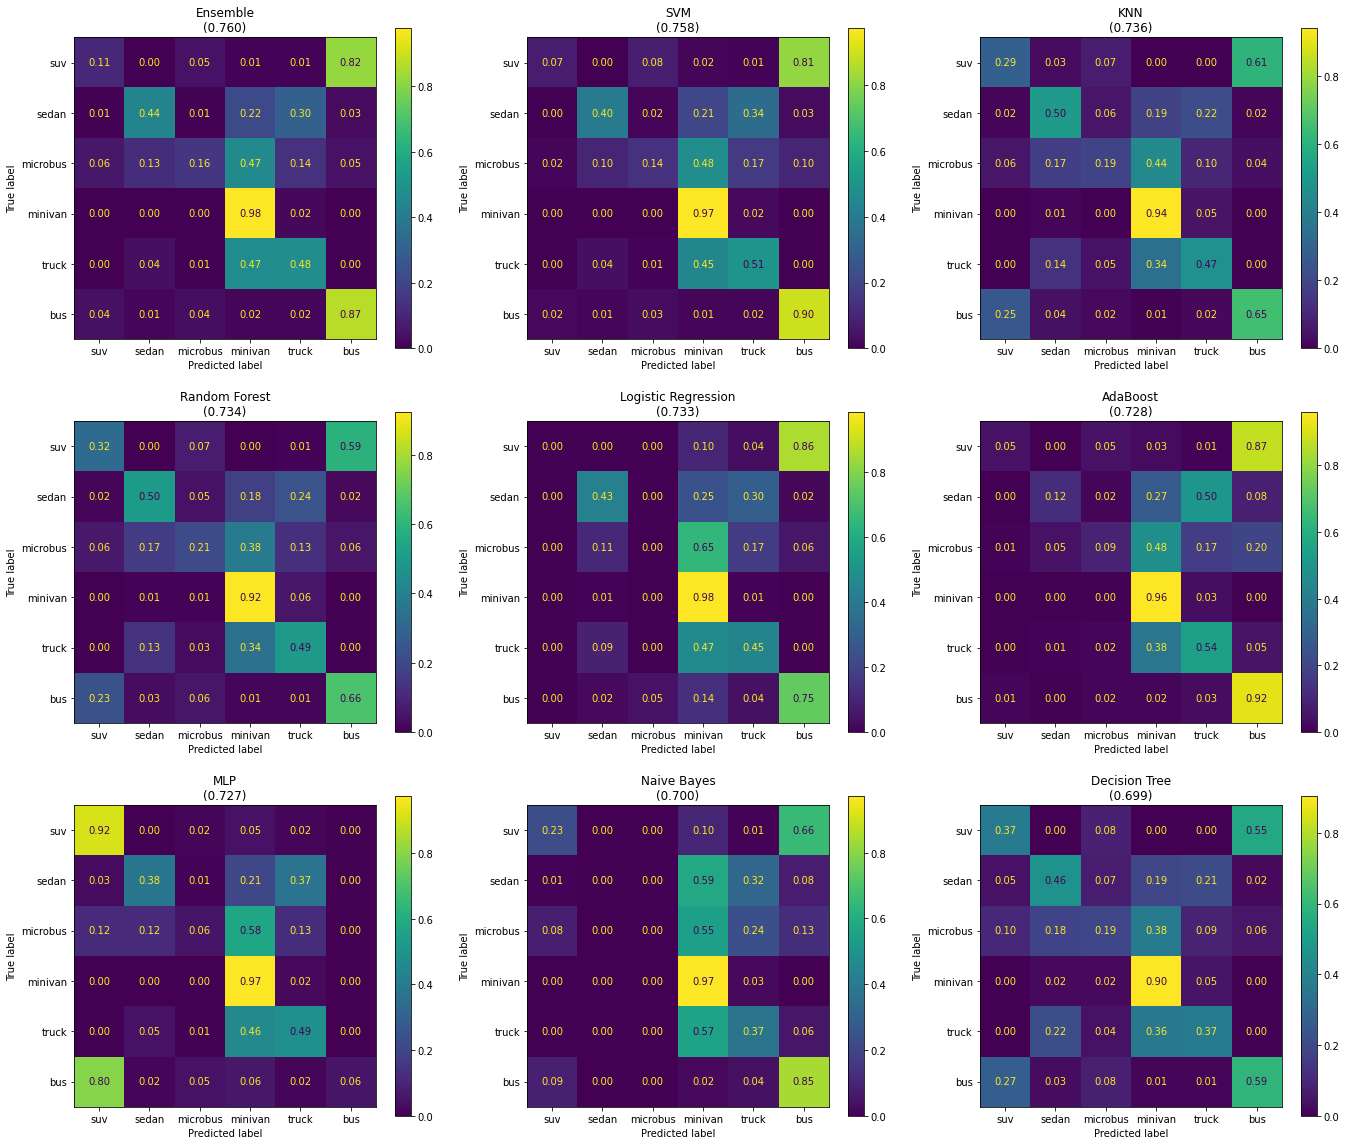

In [59]:
fig = plt.subplots(figsize=(23,20))
ax = [plt.subplot(f'33{i+1}') for i in range(9)]

# set plot titles
[ax[i]. for i, name in enumerate(result['show_name'])]

for i, name in enumerate(result['name']):
    plot_confusion_matrix(models[name],
                          test,
                          test.index,
                          normalize='true',
                          values_format='.2f',
                          display_labels=df.index.unique(),
                          title=result['show_name'][i],
                          ax=ax[i])

#### Explanation
...


### Decision Surface

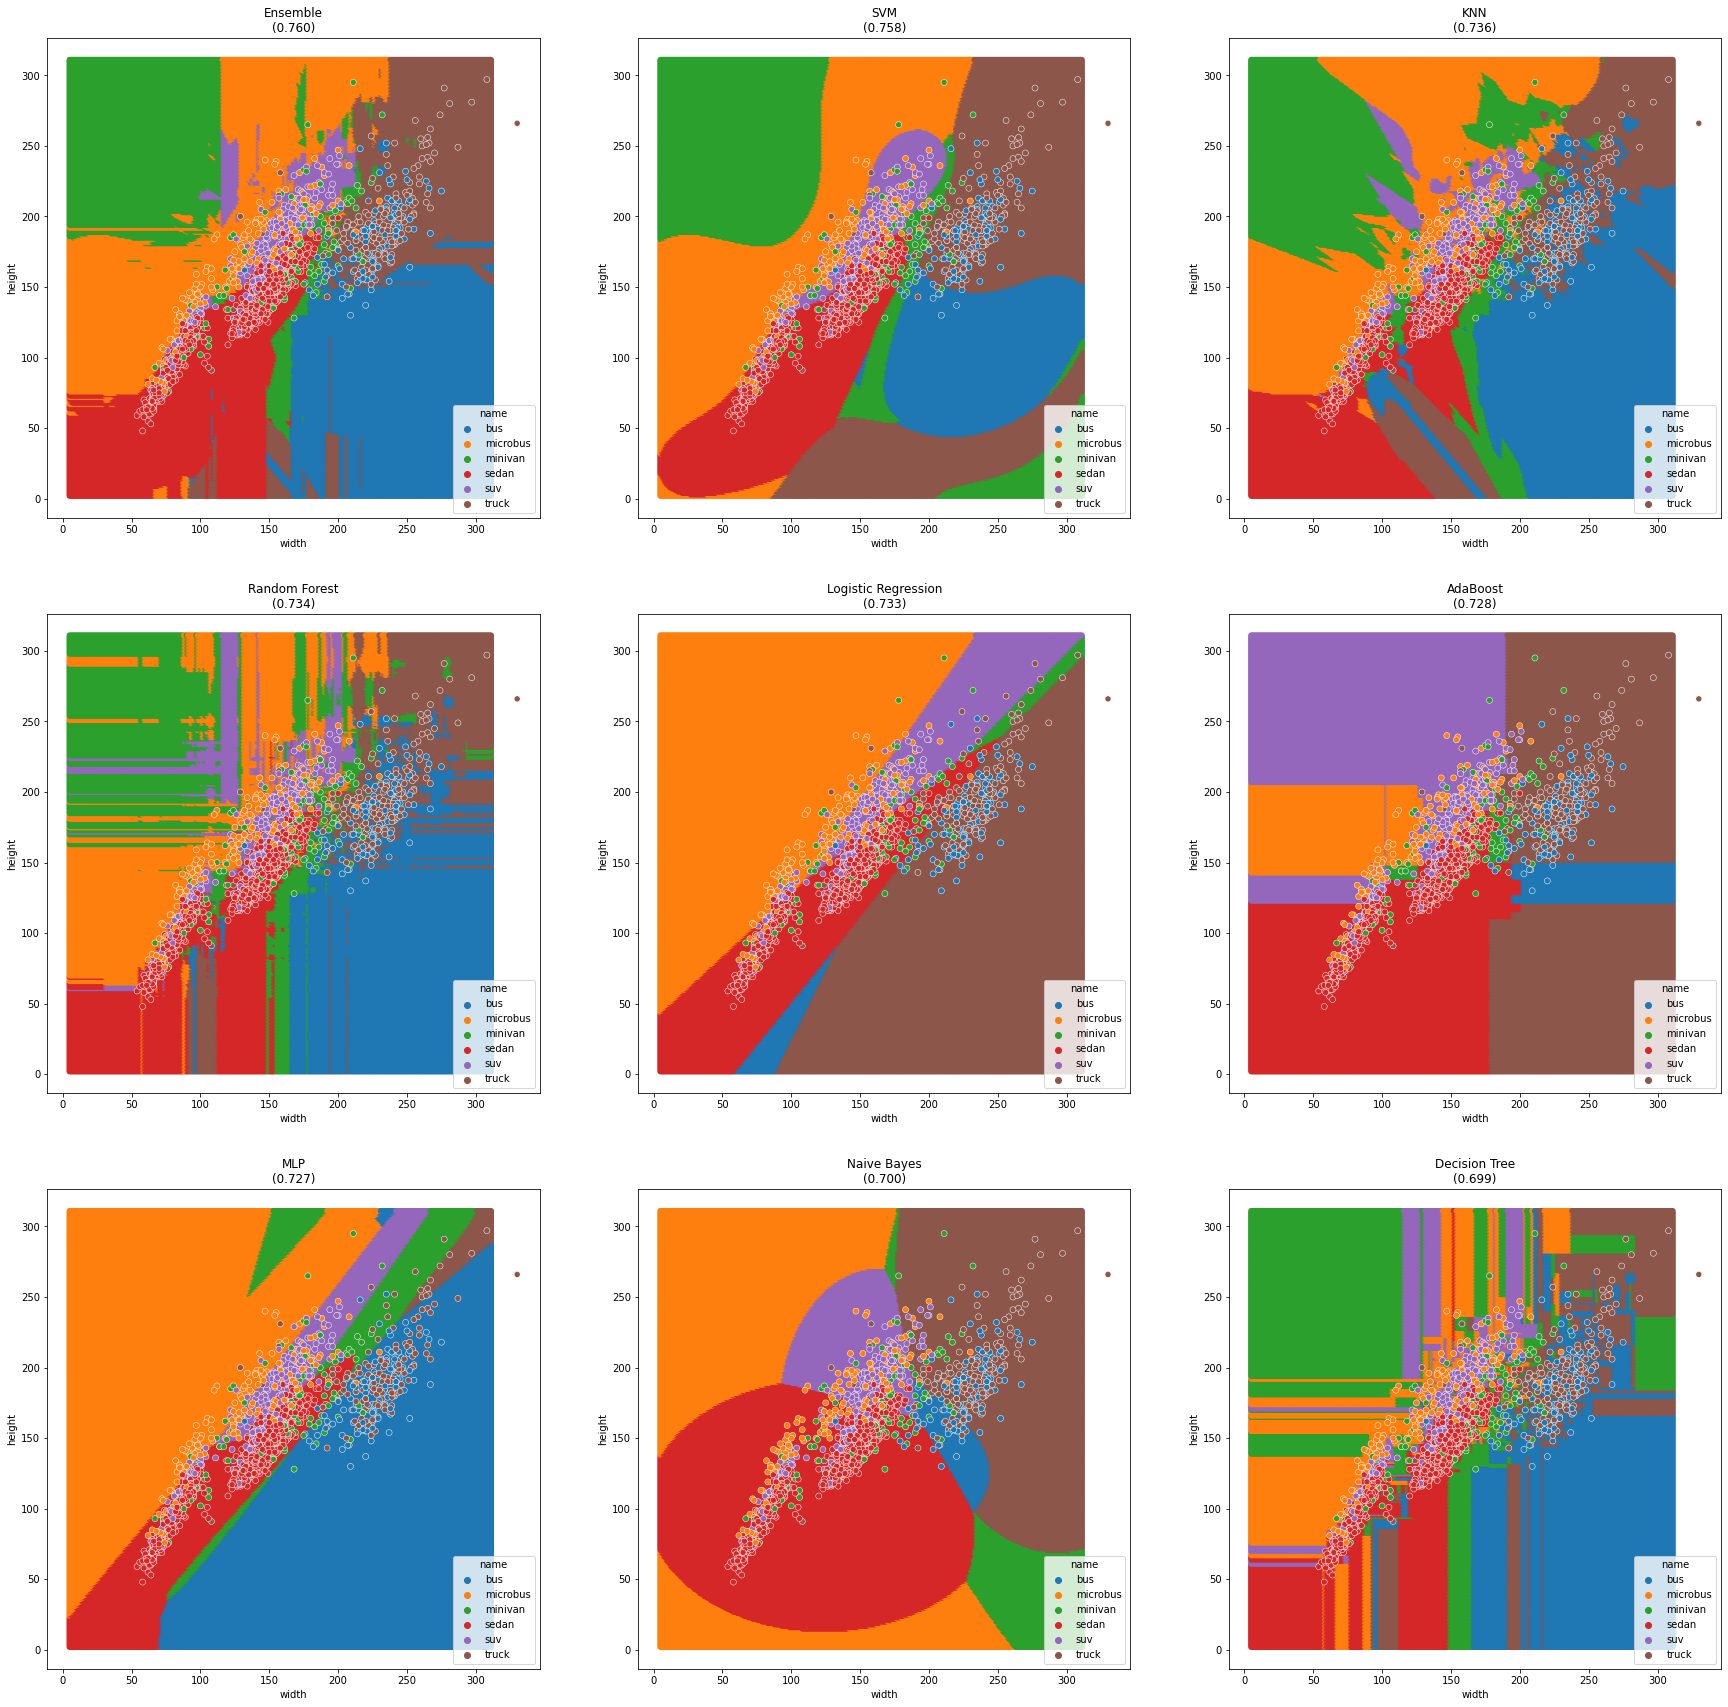

In [60]:
fig = plt.subplots(figsize=(30,30))
ax = [plt.subplot(f'33{i+1}') for i in range(9)]
[ax[i].set_title(name) for i, name in enumerate(result['show_name'])] # set plot titles

for i,name in enumerate(result['name']):
    plot_decision_surface(models[name],
                          train,
                          test,
                          ax=ax[i])

#### Explanation
...


## Model Examination

### Desicion Tree

#### Tree

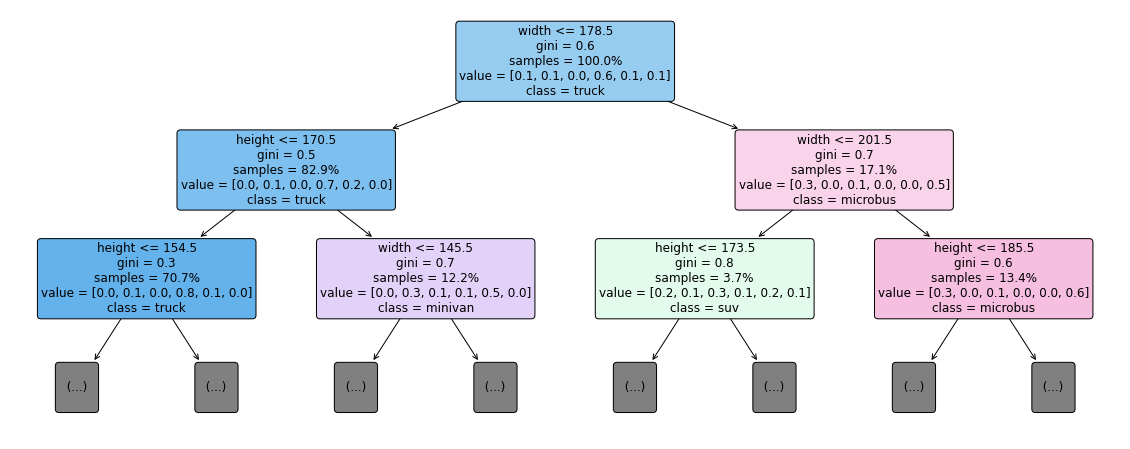

In [61]:
tree.plot_tree(models['Decision Tree'],
               feature_names=train.columns,
               class_names=train.index.unique(),
               filled=True,
               rounded=True,
               proportion=True,
               max_depth=2,
               precision=1,
               fontsize=12,
               ax=plt.figure(figsize=(20, 8)).add_subplot());

#### Decision Surface

In [127]:
from matplotlib import animation, rc
from IPython.display import HTML
%matplotlib inline
%matplotlib notebook

params = {
    'max_depth': list(range(1, 10))
}
param_list = list(itertools.product(*params.values()))
params_ = [dict(zip(params.keys(), param)) for param in param_list]

models_ = [DecisionTreeClassifier(**param).fit(train, train.index) for param in params_]
fig = plt.figure(figsize=(10, 10))
def animate(i):
    plt.clf()
    plot_decision_surface(model=models_[i],
                          train=train,
                          test=test,
                          ax=fig.add_subplot(),
                          title='DecisionTree' + param_full_name(params_[i]))
                        
animation.FuncAnimation(fig,
                        animate,
                        frames=len(param_list),
                        interval=1000)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py", line 196, in process
    func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/matplotlib/animation.py", line 1467, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


#### Parameter Tuning

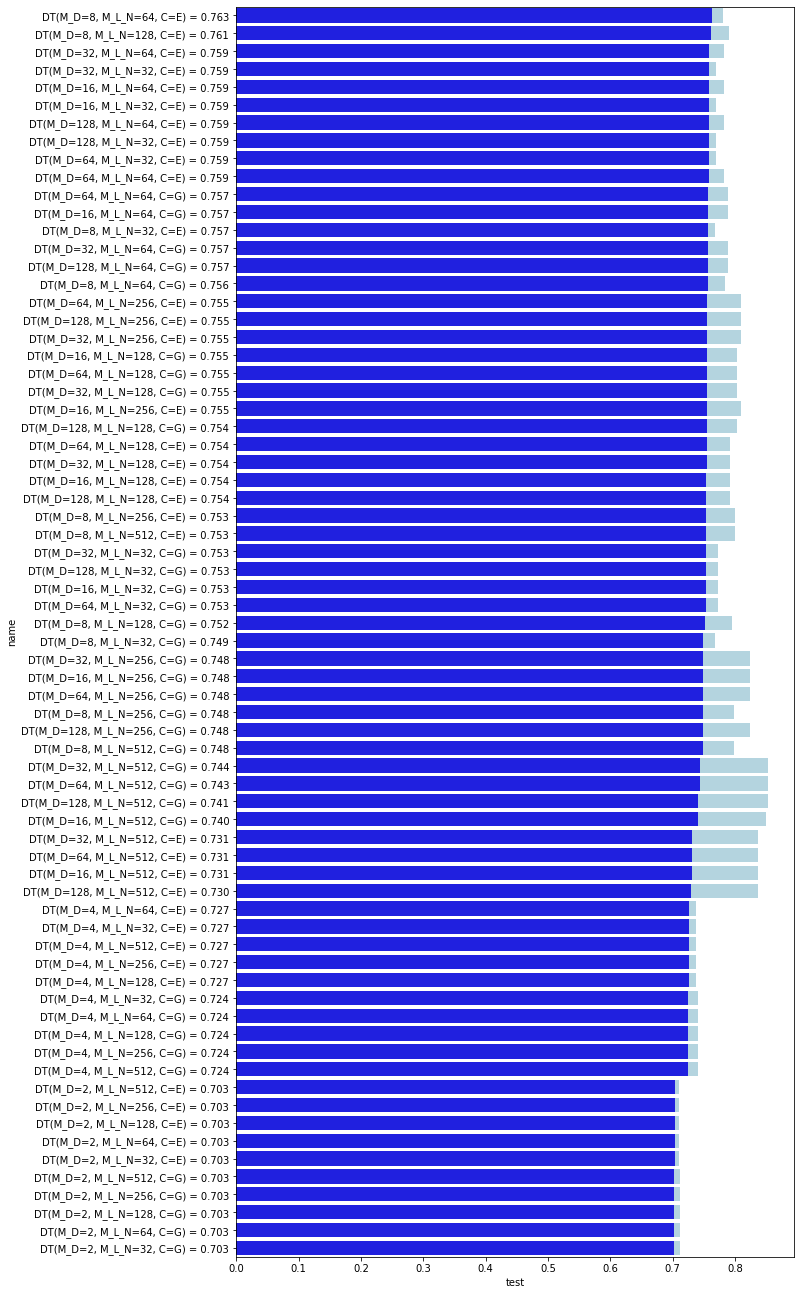

In [62]:
model_test(train=train,
           test=test,
           model=DecisionTreeClassifier,
           params={
               'max_depth': [2**i for i in range(1, 8)], 
               'max_leaf_nodes': [2**i for i in range(5, 10)],
               'criterion': ['gini', 'entropy'],
            #    'splitter': ['best', 'random']
               })

### Logistic Regression

#### Decision Surface

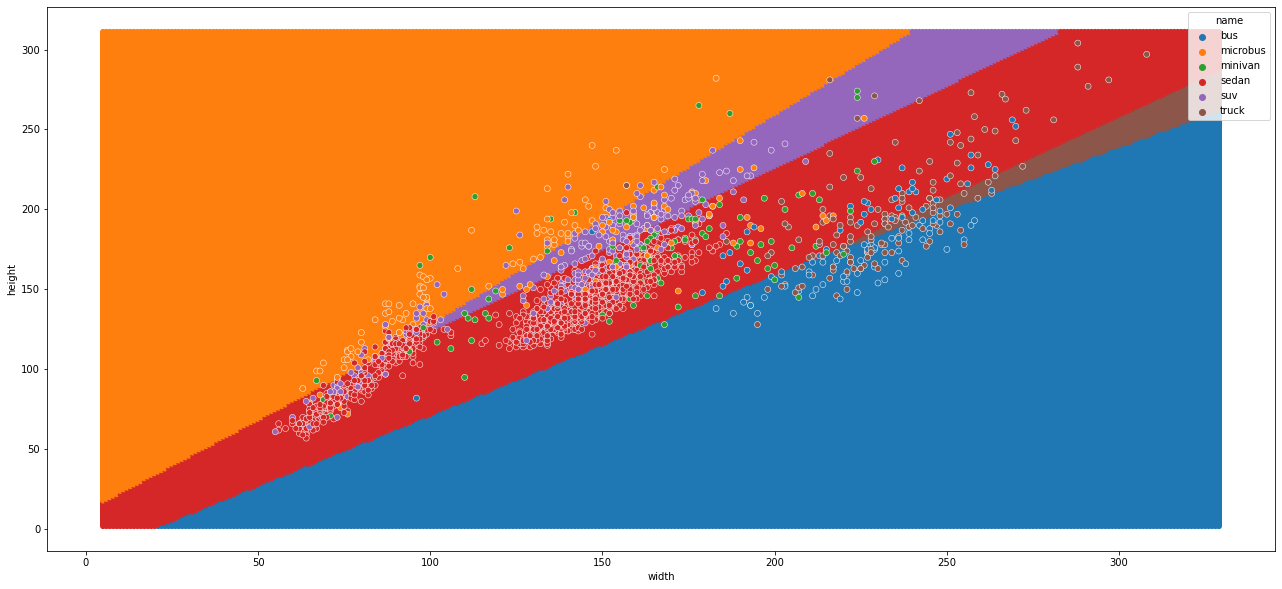

In [70]:
plot_decision_surface(model=models['Logistic Regression'],
                      train=train,
                      test=test);

#### Parameter Tuning

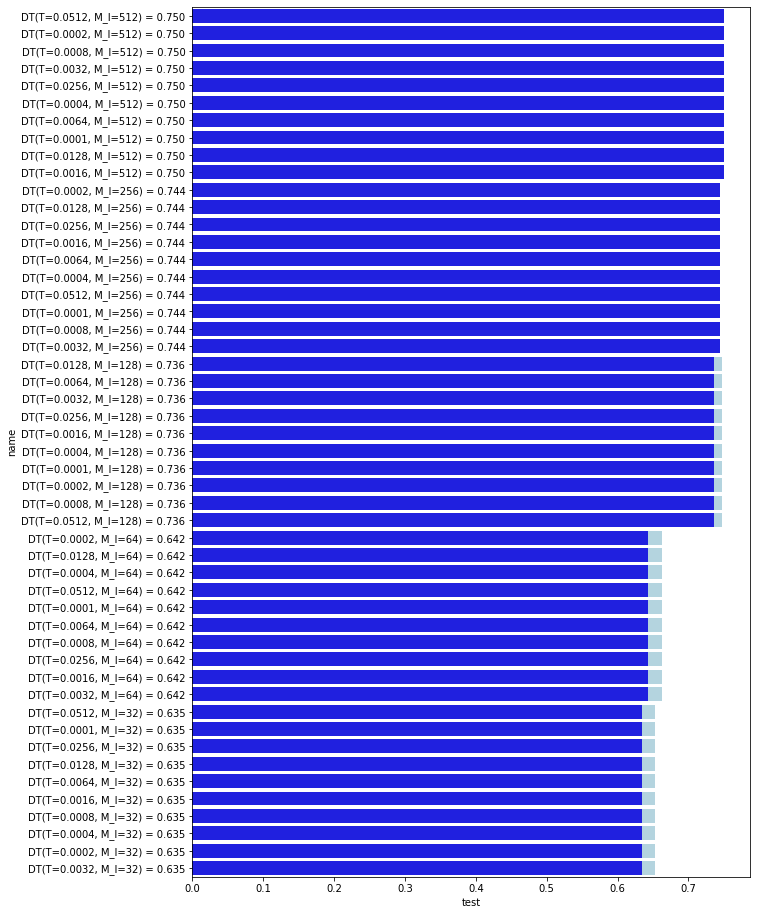

In [64]:
model_test(train=train,
           test=test,
           model=LogisticRegression,
           params={
               'tol': [2**i / 10**4 for i in range(10)],
               'max_iter': [2**i for i in range(5, 10)]
               })

### Random Forest

#### Tree

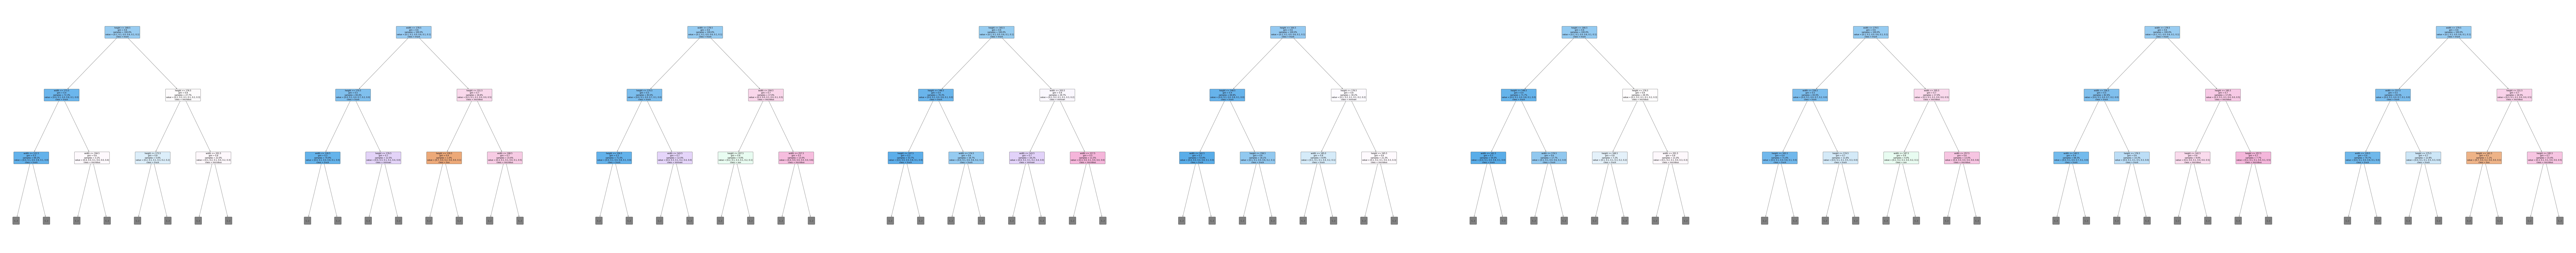

In [65]:
estimators_n = min(len(models['Random Forest'].estimators_), 9)
fig = plt.subplots(figsize=(estimators_n*40, estimators_n*4))
ax = [plt.subplot(f'1{estimators_n}{i+1}') for i in range(estimators_n)]

for i in range(estimators_n):
    tree.plot_tree(models['Random Forest'].estimators_[i],
                   feature_names=train.columns,
                   class_names=train.index.unique(),
                   filled=True, rounded=True, proportion=True, max_depth=2,
                   precision=1, fontsize=15, ax=ax[i]);

# output can be seen in fullscreen mode

### SVM